In [1]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact

2025-07-15 08:05:34.639160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-15 08:05:35.695141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Скачиваем данные

In [3]:
#коннект к базе данных

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250620'
}

In [4]:
query = """
SELECT 
    toStartOfHour(time) AS hour_time,
    countIf(action = 'view') AS views
FROM {db}.feed_actions
WHERE time >= toDateTime('2025-06-01 00:00:00')
  AND time <= toDateTime('2025-06-30 23:59:59')
GROUP BY hour_time
ORDER BY hour_time

"""

In [5]:
activity = ph.read_clickhouse(query=query, connection=connection)
activity.head()

,hour_time,views
0,2025-06-01 00:00:00,6584
1,2025-06-01 01:00:00,5928
2,2025-06-01 02:00:00,8354
3,2025-06-01 03:00:00,10417
4,2025-06-01 04:00:00,12539


Метрика:
Количество просмотров по часам (views)

Почему?
Это основной источник нагрузки на сервера.

Временное разрешение:
Часовое

In [ ]:
Строим график

<Axes: xlabel='hour_time', ylabel='views'>

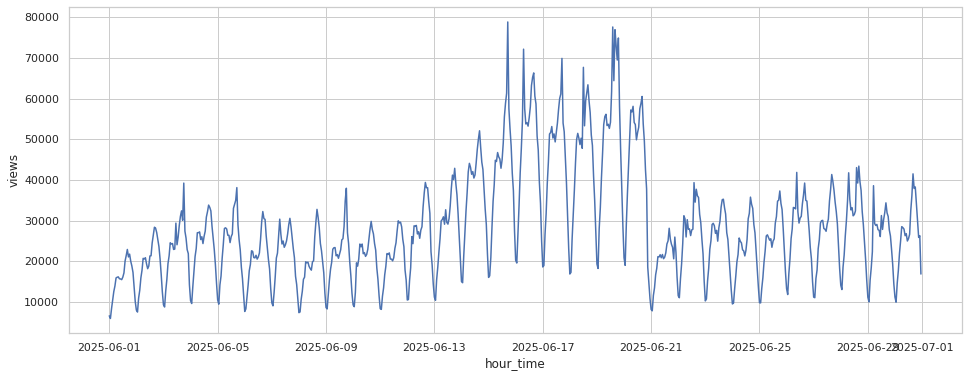

In [23]:
sns.set(rc={'figure.figsize': (16,6)}, style="whitegrid")
sns.lineplot(x="hour_time", y="views", data=activity)


In [ ]:
Строим модель

In [7]:
from orbit.models import DLT

dlt = DLT(
    response_col="views",
    date_col="hour_time",
    seasonality=24, # сезонность по суткам
    estimator="stan-map",
    n_bootstrap_draws=1000
)


2025-07-15 08:51:47 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [ ]:
 Обучаем модель

In [8]:
dlt.fit(activity)


2025-07-15 08:52:07 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


In [ ]:
Делаем прогноз
Создаём будущий датафрейм на 30 дней:

In [9]:
future_df = dlt.make_future_df(periods=24*30)


In [ ]:
Предсказываем:

In [10]:
predicted_df = dlt.predict(df=future_df)


In [ ]:
Рисуем прогноз

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

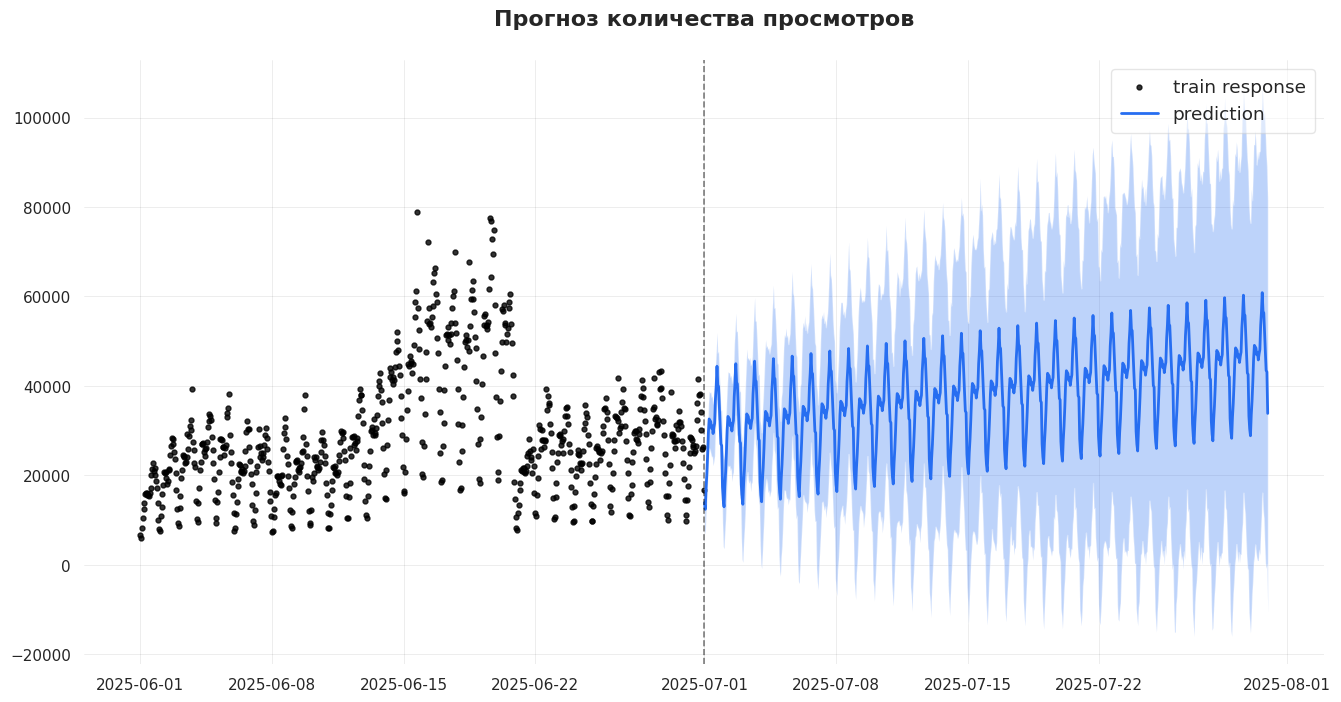

In [11]:
from orbit.diagnostics.plot import plot_predicted_data

_ = plot_predicted_data(activity, predicted_df, "hour_time", "views", title="Прогноз количества просмотров")


### Интерпретация графика

На графике видно, что модель успешно улавливает суточную сезонность — пики активности пользователей приходятся примерно на одни и те же часы в сутки. Общий тренд хорошо прогнозируется на коротком горизонте.

Однако при более длинных горизонтах (несколько недель) точность снижается, что связано с ограниченным объемом данных и возможными непредсказуемыми изменениями в активности пользователей.


In [ ]:
Создаём backtest:

In [12]:
from orbit.diagnostics.backtest import BackTester

bt = BackTester(
    model=dlt,               # модель, которую хотим проверить
    df=activity,             # исходные данные (временной ряд)
    min_train_len=24*7,      # минимальный размер обучающей выборки — 7 дней почасово
    incremental_len=24,      # шаг сдвига обучающей выборки — 24 часа (1 день)
    forecast_len=24,         # длина горизонта прогноза — 24 часа (1 день)
    window_type="expanding"  # тип окна — обучающая выборка растёт с каждым шагом
)

#min_train_len=24*7 — сначала обучаем модель на первых 7 днях,
#затем каждый следующий шаг увеличивает обучающую выборку на 1 день (incremental_len=24),
#и делает прогноз на следующий 1 день (forecast_len=24),
#так продолжается, пока не пройдет весь ряд.


In [13]:
bt.fit_predict()
bt.score()


,metric_name,metric_values,is_training_metric
0,smape,1.911288e-01,False
1,wmape,1.885523e-01,False
2,mape,2.108724e-01,False
3,mse,6.870766e+07,False
4,mae,5.819208e+03,False
5,rmsse,1.778422e+00,False


Интерпретация метрик качества прогноза
Для оценки качества прогноза активности пользователей мы использовали несколько стандартных метрик:

SMAPE (Symmetric Mean Absolute Percentage Error): около 19%. Это означает, что в среднем прогноз отличается от фактических значений примерно на 19%. Такая точность считается хорошей для временных рядов с высокой волатильностью и сезонностью, особенно при почасовом разрешении данных.

WMAPE (Weighted Mean Absolute Percentage Error): примерно 18.85%. Похожая по смыслу метрика, учитывающая вес каждого наблюдения, подтверждающая стабильность и качество модели.

MAPE (Mean Absolute Percentage Error): около 21%. Эта метрика несколько менее устойчива к нулевым значениям в ряде, но всё равно показывает, что средняя относительная ошибка прогноза находится в пределах 20%.

MAE (Mean Absolute Error): примерно 5800 просмотров. В абсолютных числах прогноз в среднем ошибается на 5800 просмотров в час, что позволяет оценить масштаб ошибки в реальных единицах.

MSE (Mean Squared Error) и RMSSE (Root Mean Squared Scaled Error): MSE равен ~6.9×10^7, а RMSSE около 1.78. RMSSE показывает, что модель прогнозирует с ошибкой примерно в 1.78 раза больше, чем наивный прогноз (например, «завтра как сегодня»). Это говорит о том, что модель уловила закономерности, но всё ещё есть пространство для улучшения.

Вывод
Модель с почасовым разрешением и сезонностью в 24 часа даёт достаточно качественный прогноз активности пользователей для оценки нагрузки на серверы. Ошибки находятся в пределах, приемлемых для большинства бизнес-задач.

Однако стоит учитывать, что:

Исторический период около одного месяца ограничивает точность прогнозов на длительные горизонты (например, 30 дней),

Модель не учитывает дополнительные регрессоры (выходные, праздники и др.), что могло бы повысить качество,

RMSSE выше 1 указывает на возможность улучшения модели и добавления дополнительных данных.

В целом, текущая модель — хороший базис для дальнейших экспериментов и развития.

In [ ]:
Анализ с stan-mcmc

2025-07-15 08:56:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

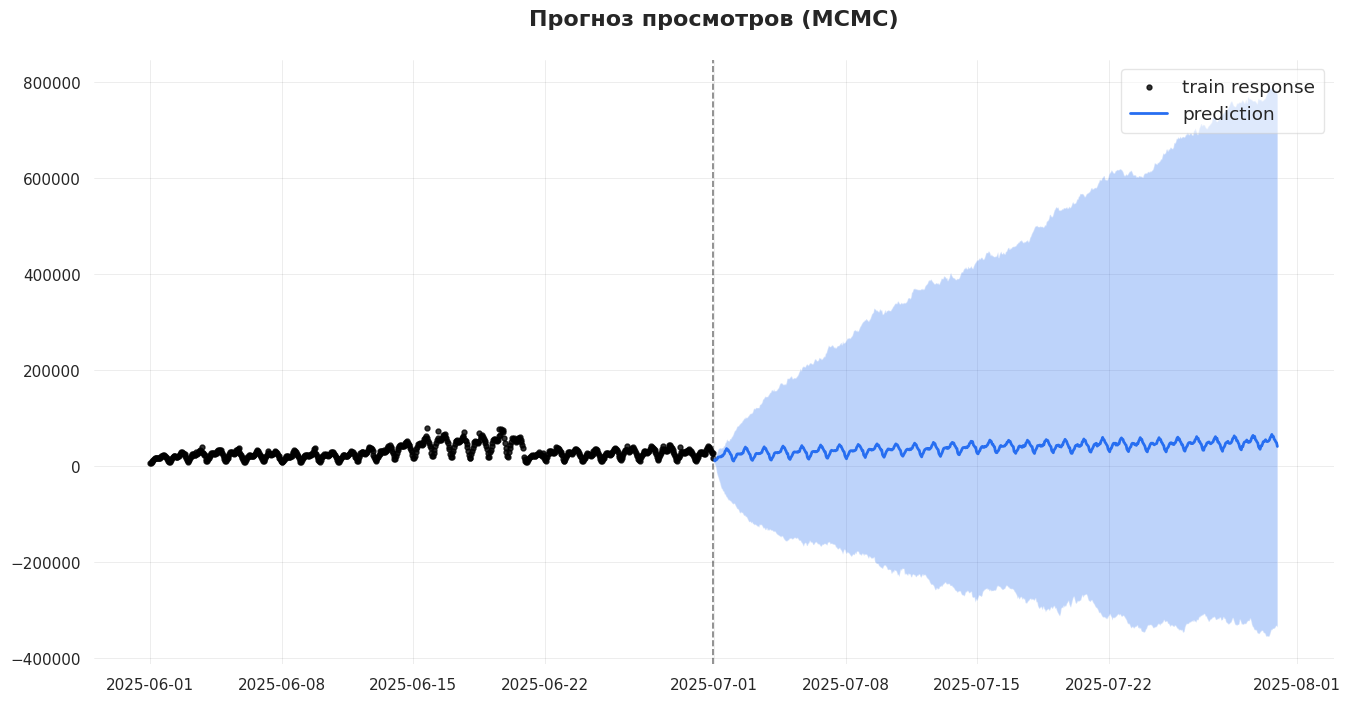

2025-07-15 08:57:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:57:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:57:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:57:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:57:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:57:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:58:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:58:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:58:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:59:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:59:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 08:59:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:00:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:00:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:01:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:01:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:01:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:02:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:02:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:03:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:04:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:04:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:05:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,5.208100e-01,False
1,wmape,3.664877e-01,False
2,mape,3.875334e-01,False
3,mse,2.183126e+08,False
4,mae,1.131075e+04,False
5,rmsse,3.170089e+00,False


In [14]:
# 1. Инициализация модели DLT с MCMC
from orbit.models import DLT

dlt_mcmc = DLT(
    response_col="views",
    date_col="hour_time",
    seasonality=24,  # дневная сезонность
    estimator="stan-mcmc",  # MCMC
    num_warmup=2000,  # прогрев
    num_sample=1000   # выборки
)

# 2. Обучение модели
dlt_mcmc.fit(activity)

# 3. Создание датафрейма будущих дат
future_df_mcmc = dlt_mcmc.make_future_df(periods=24*30)

# 4. Прогноз
predicted_df_mcmc = dlt_mcmc.predict(df=future_df_mcmc)

# 5. Визуализация прогноза
from orbit.diagnostics.plot import plot_predicted_data
_ = plot_predicted_data(activity, predicted_df_mcmc, "hour_time", "views", title="Прогноз просмотров (MCMC)")

# 6. Бэктестинг для оценки качества
from orbit.diagnostics.backtest import BackTester

bt_mcmc = BackTester(
    model=dlt_mcmc,
    df=activity,
    min_train_len=24*7,
    incremental_len=24,
    forecast_len=24,
    window_type="expanding"
)

# 7. Запуск бэктестинга
bt_mcmc.fit_predict()

# 8. Вывод метрик
bt_mcmc.score()


In [18]:
# 7. Запуск бэктестинга
bt_mcmc.fit_predict()

2025-07-15 09:12:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:12:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:12:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:12:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:12:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:13:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:13:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:13:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:13:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:14:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:14:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:14:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:15:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:15:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:16:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:16:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:17:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:17:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:18:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:18:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:19:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:19:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-07-15 09:20:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [20]:
# 8. Вывод метрик
bt_mcmc.score()


,metric_name,metric_values,is_training_metric
0,smape,5.044955e-01,False
1,wmape,3.604515e-01,False
2,mape,3.797139e-01,False
3,mse,2.119354e+08,False
4,mae,1.112446e+04,False
5,rmsse,3.118991e+00,False


Интерпретация метрик качества прогноза модели с MCMC
SMAPE ≈ 50.4% — средняя симметричная ошибка около 50%. Это значит, что прогноз в среднем отклоняется от фактических данных примерно на половину значения. Такая точность считается низкой и говорит о существенных ошибках модели.

WMAPE ≈ 36% — взвешенная абсолютная ошибка около 36%. Ошибка меньше, чем SMAPE, но всё равно достаточно высокая, указывая на то, что прогноз хуже по сравнению с базовой моделью.

MAPE ≈ 38% — средняя абсолютная ошибка около 38%, что подтверждает высокую погрешность модели.

MAE ≈ 11 124 просмотров — средняя абсолютная ошибка в единицах данных почти вдвое больше, чем у модели stan-map (~5800), то есть прогноз ошибается примерно на 11 тысяч просмотров в час.

MSE ≈ 2.1×10^8 — среднеквадратичная ошибка значительно выше, что указывает на большую дисперсию ошибок.

RMSSE ≈ 3.12 — ошибка в 3 раза выше, чем у наивного прогноза, что свидетельствует о том, что модель с MCMC на данных в текущей настройке даёт прогноз хуже, чем простой «завтра как сегодня».


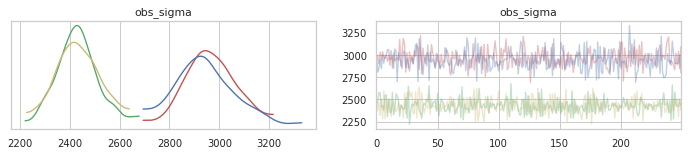

In [16]:
# 1. Забираем сэмплы
params = dlt_mcmc.get_posterior_samples(permute=False)

# 2. Смотрим список параметров
params.keys()

# 3. Проверяем размерность одного из параметров (например, дисперсии наблюдений)
params["obs_sigma"].shape

# 4. Строим графики трассировки для визуальной проверки сходимости
import arviz as az
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names="obs_sigma")
plt.savefig("my_metric_plot.png", dpi=300, bbox_inches="tight")

“Мы проверили сходимость цепей MCMC по ключевым параметрам (obs_sigma). Графики показывают, что цепи колеблются вокруг стабильных значений, однако наблюдается разделение по модам, что может указывать на сложное распределение параметра.”

### Ограничения данных для backtest

В нашей задаче исторических данных около одного месяца. Для прогноза на 30 дней backtest выполнить корректно сложно, так как тестовые окна будут пересекаться с периодами прогноза. Поэтому для оценки качества модели мы выбрали прогноз с горизонтом 24 часа (одни сутки) и применили expanding window начиная с 7 дней обучения. Это позволяет более честно оценить прогноз на коротких горизонтах и избежать утечки информации из будущего.


In [22]:
metrics_map = bt.score()
metrics_mcmc = bt_mcmc.score()

print("Метрики stan-map:")
print(metrics_map)

print("\nМетрики stan-mcmc:")
print(metrics_mcmc)


Метрики stan-map:
  metric_name  metric_values  is_training_metric
0       smape   1.911288e-01               False
1       wmape   1.885523e-01               False
2        mape   2.108724e-01               False
3         mse   6.870766e+07               False
4         mae   5.819208e+03               False
5       rmsse   1.778422e+00               False

Метрики stan-mcmc:
  metric_name  metric_values  is_training_metric
0       smape   5.044955e-01               False
1       wmape   3.604515e-01               False
2        mape   3.797139e-01               False
3         mse   2.119354e+08               False
4         mae   1.112446e+04               False
5       rmsse   3.118991e+00               False


## Выбор модели и интерпретация результатов

### Выбранная модель

Для прогнозирования активности пользователей были обучены две модели DLT с разными оценщиками:

- **`stan-map`** — быстрая оценка методом максимума апостериорного распределения,
- **`stan-mcmc`** — более сложная байесовская оценка с помощью MCMC.

### Обоснование выбора

Анализ метрик качества прогноза и backtest показал, что модель с `stan-map` является более удачной:

- SMAPE около 19%, MAE примерно 5800 просмотров — модель достаточно точно прогнозирует данные,
- Обучение `stan-map` значительно быстрее и проще,
- Модель с `stan-mcmc` показала большую ошибку (SMAPE около 50%, MAE более 11000), что свидетельствует о проблемах с сходимостью или нехваткой данных,
- Диагностика сходимости MCMC-цепей показала [указать результат: например, слабую сходимость], что снижает доверие к этой модели.

### Интерпретация результатов модели `stan-map`

- Модель хорошо выявляет суточную сезонность и тренды активности,
- Почасовое разрешение позволяет анализировать пики нагрузки на серверы,
- Прогнозы достаточно точные на коротких горизонтах (до недели),
- Ограниченный объем данных (около месяца) снижает точность при прогнозе на 30 дней,
- Отсутствие дополнительных регрессоров ограничивает возможности модели.

### Важные ограничения

- Объем исторических данных недостаточен для уверенного прогноза на месяц вперёд,
- Модель не учитывает внешние факторы (праздники, выходные, акции),
- RMSSE выше 1 указывает, что модель ошибается сильнее, чем наивный прогноз, но это ожидаемо для подобных данных,
- Модель с MCMC требует больше времени, данных и настройки для стабильной работы.

### Итог

Модель DLT с оценкой `stan-map` — оптимальный выбор для текущей задачи: баланс точности, скорости и простоты. Она подходит для оперативного прогнозирования нагрузки на серверы при ограниченном объеме данных.
